# ResNet-Lite Autoencoder Training

Training a lighter ResNet-style autoencoder with residual blocks.

**Key differences from baseline:**
- Residual blocks with skip connections for better gradient flow
- **ResNet-Lite**: base_channels=32 (~5.6M params vs 22M full ResNet)
- **Mixed Precision (AMP)**: ~2x training speedup
- Same 16x compression (16x16x16 latent)
- Expected: +2-3 dB PSNR improvement over baseline

**Targets:**
- Validation PSNR > 25 dB (baseline achieved ~20.5 dB)
- Training time < 1 day

## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: d:\Projects\CNNAutoencoderProject


In [2]:
import torch
import torch.nn as nn

# Project imports
from src.data.datamodule import SARDataModule
from src.models.resnet_autoencoder import ResNetAutoencoder  # ResNet version!
from src.losses.combined import CombinedLoss
from src.training.trainer import Trainer

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


## 2. Configuration

In [3]:
# ============================================================
# CONFIGURATION - ResNet-Lite with AMP
# ============================================================

# Data settings
DATA_PATH = "D:/Projects/CNNAutoencoderProject/data/patches/metadata.npy"
BATCH_SIZE = 32       # Can use larger batch with AMP + smaller model
NUM_WORKERS = 4       # Parallel data loading
VAL_FRACTION = 0.1    # 10% validation split
TRAIN_SUBSET = 0.20   # Use 20% of data for faster iteration

# Model settings - LITE VERSION
LATENT_CHANNELS = 16  # 16 = 16x compression
BASE_CHANNELS = 32    # REDUCED from 64 -> ~5.6M params (vs 22M)

# Loss settings
MSE_WEIGHT = 0.5
SSIM_WEIGHT = 0.5

# Training settings
EPOCHS = 50
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 5
LR_FACTOR = 0.5
MAX_GRAD_NORM = 1.0
USE_AMP = True        # Mixed precision for ~2x speedup

# Output settings
RUN_NAME = f"resnet_lite_c{LATENT_CHANNELS}"

# Calculate compression ratio
compression_ratio = (256 * 256) / (16 * 16 * LATENT_CHANNELS)
print(f"Model: ResNet-Lite Autoencoder")
print(f"Base channels: {BASE_CHANNELS} (lite version)")
print(f"Compression ratio: {compression_ratio:.0f}x")
print(f"Training subset: {TRAIN_SUBSET*100:.0f}% of data")
print(f"Batch size: {BATCH_SIZE}")
print(f"Mixed Precision (AMP): {USE_AMP}")

Model: ResNet-Lite Autoencoder
Base channels: 32 (lite version)
Compression ratio: 16x
Training subset: 20% of data
Batch size: 32
Mixed Precision (AMP): True


## 3. Load Data

In [4]:
print("Loading data...")
dm = SARDataModule(
    patches_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_fraction=VAL_FRACTION,
)

# Apply subset to BOTH train and val for faster iteration
if TRAIN_SUBSET < 1.0:
    import random
    
    # Subset training data
    full_train_size = len(dm.train_dataset)
    train_subset_size = int(full_train_size * TRAIN_SUBSET)
    train_indices = random.sample(range(full_train_size), train_subset_size)
    dm.train_dataset = torch.utils.data.Subset(dm.train_dataset, train_indices)
    
    # Subset validation data (same proportion)
    full_val_size = len(dm.val_dataset)
    val_subset_size = int(full_val_size * TRAIN_SUBSET)
    val_indices = random.sample(range(full_val_size), val_subset_size)
    dm.val_dataset = torch.utils.data.Subset(dm.val_dataset, val_indices)
    
    print(f"Using {TRAIN_SUBSET*100:.0f}% subset:")
    print(f"  Train: {train_subset_size:,} of {full_train_size:,}")
    print(f"  Val: {val_subset_size:,} of {full_val_size:,}")

train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

print(f"\nDataset loaded:")
print(f"  Train patches: {len(dm.train_dataset):,}")
print(f"  Val patches: {len(dm.val_dataset):,}")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches: {len(val_loader):,}")
print(f"  Preprocessing params: {dm.preprocessing_params}")

# Estimate epoch time
est_batches = len(train_loader) + len(val_loader)
est_time_min = est_batches / 1.5 / 60  # ~1.5 it/s with larger model
print(f"\n  Estimated time per epoch: ~{est_time_min:.0f} minutes")

Loading data...
Loading metadata from D:\Projects\CNNAutoencoderProject\data\patches\metadata.npy
Total patches: 696277
Train: 626650, Val: 69627
Using 20% subset:
  Train: 125,330 of 626,650
  Val: 13,925 of 69,627

Dataset loaded:
  Train patches: 125,330
  Val patches: 13,925
  Train batches: 3,916
  Val batches: 436
  Preprocessing params: {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}

  Estimated time per epoch: ~48 minutes


In [5]:
# Verify a sample batch
sample_batch = next(iter(train_loader))
print(f"Sample batch shape: {sample_batch.shape}")
print(f"Sample batch dtype: {sample_batch.dtype}")
print(f"Sample batch range: [{sample_batch.min():.4f}, {sample_batch.max():.4f}]")

Sample batch shape: torch.Size([32, 1, 256, 256])
Sample batch dtype: torch.float32
Sample batch range: [0.0000, 1.0000]


## 4. Create Model

In [6]:
print("Creating ResNet model...")
model = ResNetAutoencoder(
    latent_channels=LATENT_CHANNELS,
    base_channels=BASE_CHANNELS,
)

params = model.count_parameters()
print(f"\nModel created:")
print(f"  Architecture: ResNetAutoencoder")
print(f"  Total parameters: {params['total']:,}")
print(f"  Encoder params: {params['encoder']:,}")
print(f"  Decoder params: {params['decoder']:,}")
print(f"  Compression ratio: {model.get_compression_ratio():.1f}x")
print(f"  Latent size: {model.get_latent_size()}")

# Compare to baseline
baseline_params = 2_257_809
print(f"\n  vs Baseline: {params['total'] / baseline_params:.1f}x more parameters")

Creating ResNet model...

Model created:
  Architecture: ResNetAutoencoder
  Total parameters: 5,648,033
  Encoder params: 2,820,544
  Decoder params: 2,827,489
  Compression ratio: 16.0x
  Latent size: (16, 16, 16)

  vs Baseline: 2.5x more parameters


In [7]:
# Test forward pass
print("Testing forward pass...")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_test = model.to(device)
x_test = sample_batch[:2].to(device)

with torch.no_grad():
    x_hat, z = model_test(x_test)

print(f"  Input: {x_test.shape}")
print(f"  Latent: {z.shape}")
print(f"  Output: {x_hat.shape}")
print(f"  Output range: [{x_hat.min():.4f}, {x_hat.max():.4f}]")

# Check GPU memory
if torch.cuda.is_available():
    print(f"  GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

# Clean up test
del model_test, x_test, x_hat, z
torch.cuda.empty_cache()

Testing forward pass...
  Input: torch.Size([2, 1, 256, 256])
  Latent: torch.Size([2, 16, 16, 16])
  Output: torch.Size([2, 1, 256, 256])
  Output range: [0.0000, 1.0000]
  GPU memory allocated: 0.02 GB


## 5. Create Loss Function

In [8]:
loss_fn = CombinedLoss(
    mse_weight=MSE_WEIGHT,
    ssim_weight=SSIM_WEIGHT,
)

print(f"Loss function: CombinedLoss")
print(f"  MSE weight: {MSE_WEIGHT}")
print(f"  SSIM weight: {SSIM_WEIGHT}")

Loss function: CombinedLoss
  MSE weight: 0.5
  SSIM weight: 0.5


## 6. Initialize Trainer

In [9]:
# Training configuration
config = {
    'learning_rate': LEARNING_RATE,
    'lr_patience': LR_PATIENCE,
    'lr_factor': LR_FACTOR,
    'max_grad_norm': MAX_GRAD_NORM,
    'run_name': RUN_NAME,
    'preprocessing_params': dm.preprocessing_params,
    'use_amp': USE_AMP,  # Mixed precision training
    # Store hyperparams for reproducibility
    'model_type': 'ResNetAutoencoder-Lite',
    'latent_channels': LATENT_CHANNELS,
    'base_channels': BASE_CHANNELS,
    'mse_weight': MSE_WEIGHT,
    'ssim_weight': SSIM_WEIGHT,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
}

print("Initializing trainer...")
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    config=config,
)

print(f"\nTrainer ready:")
print(f"  Log dir: {trainer.log_dir}")
print(f"  Checkpoint dir: {trainer.checkpoint_dir}")
print(f"  Device: {trainer.device}")
print(f"  AMP enabled: {trainer.use_amp}")

d:\Projects\CNNAutoencoderProject\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2026-01-22 23:28:19,451 - Log directory: runs\resnet_lite_c16
2026-01-22 23:28:19,451 - Checkpoint directory: checkpoints\resnet_lite_c16
2026-01-22 23:28:19,452 - Mixed Precision (AMP): enabled


Initializing trainer...
Using device: cuda
Mixed Precision (AMP) enabled - ~2x training speedup

Trainer ready:
  Log dir: runs\resnet_lite_c16
  Checkpoint dir: checkpoints\resnet_lite_c16
  Device: cuda
  AMP enabled: True


## 7. Train Model

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=D:/Projects/CNNAutoencoderProject/notebooks/runs
```

Compare `resnet_c16` with `baseline_c16_fast` in TensorBoard.

In [10]:
print("=" * 60)
print("Starting ResNet Training")
print("=" * 60)
print(f"Model: ResNetAutoencoder ({params['total']:,} params)")
print(f"Epochs: {EPOCHS}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"\nTensorBoard: tensorboard --logdir={trainer.log_dir.parent}")
print(f"Checkpoints: {trainer.checkpoint_dir}")
print("=" * 60)

history = trainer.train(
    epochs=EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
)

2026-01-22 23:28:23,082 - Starting training for 50 epochs
2026-01-22 23:28:23,083 - Model: ResNetAutoencoder
2026-01-22 23:28:23,083 - Config: {'learning_rate': 0.0001, 'lr_patience': 5, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'run_name': 'resnet_lite_c16', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'use_amp': True, 'model_type': 'ResNetAutoencoder-Lite', 'latent_channels': 16, 'base_channels': 32, 'mse_weight': 0.5, 'ssim_weight': 0.5, 'batch_size': 32, 'epochs': 50}


Starting ResNet Training
Model: ResNetAutoencoder (5,648,033 params)
Epochs: 50
Early stopping patience: 10
Learning rate: 0.0001

TensorBoard: tensorboard --logdir=runs
Checkpoints: checkpoints\resnet_lite_c16


Epoch 1 [Val]: 100%|██████████| 436/436 [22:15<00:00,  3.06s/it, loss=0.2671, psnr=18.74, ssim=0.4791]   
2026-01-23 00:29:48,614 - New best model saved (val_loss: 0.2661)
2026-01-23 00:29:48,617 - Epoch 1/50 | Train: loss=0.2919, psnr=17.76, ssim=0.4339 | Val: loss=0.2661, psnr=18.77, ssim=0.4811 | LR: 1.00e-04 | GPU: 0.09GB
Epoch 2 [Val]: 100%|██████████| 436/436 [00:41<00:00, 10.47it/s, loss=0.1898, psnr=19.53, ssim=0.6316]
2026-01-23 00:51:17,507 - New best model saved (val_loss: 0.1916)
2026-01-23 00:51:17,508 - Epoch 2/50 | Train: loss=0.2171, psnr=18.71, ssim=0.5794 | Val: loss=0.1916, psnr=19.30, ssim=0.6285 | LR: 1.00e-04 | GPU: 0.09GB
Epoch 3 [Val]: 100%|██████████| 436/436 [00:41<00:00, 10.41it/s, loss=0.1743, psnr=20.41, ssim=0.6605]
2026-01-23 01:12:29,059 - Epoch 3/50 | Train: loss=0.1830, psnr=19.44, ssim=0.6455 | Val: loss=nan, psnr=nan, ssim=nan | LR: 1.00e-04 | GPU: 0.09GB
Epoch 4 [Val]: 100%|██████████| 436/436 [00:41<00:00, 10.55it/s, loss=0.1677, psnr=20.19, ssim=0

## 8. Training Summary

In [11]:
print("=" * 60)
print("Training Complete")
print("=" * 60)

if history:
    final = history[-1]
    print(f"Model: ResNetAutoencoder")
    print(f"Final epoch: {final['epoch'] + 1}")
    print(f"Best val loss: {trainer.best_val_loss:.4f}")
    print(f"Final val PSNR: {final['val_psnr']:.2f} dB")
    print(f"Final val SSIM: {final['val_ssim']:.4f}")
    
    # Compare to baseline
    baseline_psnr = 20.47  # From baseline training
    improvement = final['val_psnr'] - baseline_psnr
    print(f"\nImprovement over baseline: {improvement:+.2f} dB")
    
    # Check success criterion
    if final['val_psnr'] >= 25:
        print("\n" + "=" * 60)
        print("[SUCCESS] PSNR > 25 dB achieved!")
        print("=" * 60)
    else:
        print(f"\n[INFO] PSNR {final['val_psnr']:.2f} dB (target: 25 dB)")

print(f"\nBest checkpoint: {trainer.checkpoint_dir / 'best.pth'}")

Training Complete
Model: ResNetAutoencoder
Final epoch: 34
Best val loss: 0.1415
Final val PSNR: nan dB
Final val SSIM: nan

Improvement over baseline: +nan dB

[INFO] PSNR nan dB (target: 25 dB)

Best checkpoint: checkpoints\resnet_lite_c16\best.pth


## 9. Comparison with Baseline

In [12]:
# Comparison table
print("\n" + "=" * 60)
print("Model Comparison")
print("=" * 60)

baseline_results = {
    'params': 2_257_809,
    'psnr': 20.47,
    'ssim': 0.646,
    'loss': 0.1813
}

if history:
    resnet_results = {
        'params': params['total'],
        'psnr': final['val_psnr'],
        'ssim': final['val_ssim'],
        'loss': final['val_loss']
    }
    
    print(f"{'Metric':<20} {'Baseline':<15} {'ResNet':<15} {'Diff':<15}")
    print("-" * 60)
    print(f"{'Parameters':<20} {baseline_results['params']:,} {resnet_results['params']:,} {resnet_results['params']/baseline_results['params']:.1f}x")
    print(f"{'Val PSNR (dB)':<20} {baseline_results['psnr']:.2f} {resnet_results['psnr']:.2f} {resnet_results['psnr'] - baseline_results['psnr']:+.2f}")
    print(f"{'Val SSIM':<20} {baseline_results['ssim']:.3f} {resnet_results['ssim']:.3f} {resnet_results['ssim'] - baseline_results['ssim']:+.3f}")
    print(f"{'Val Loss':<20} {baseline_results['loss']:.4f} {resnet_results['loss']:.4f} {resnet_results['loss'] - baseline_results['loss']:+.4f}")


Model Comparison
Metric               Baseline        ResNet          Diff           
------------------------------------------------------------
Parameters           2,257,809 5,648,033 2.5x
Val PSNR (dB)        20.47 nan +nan
Val SSIM             0.646 nan +nan
Val Loss             0.1813 nan +nan


## 10. Visualize Training History

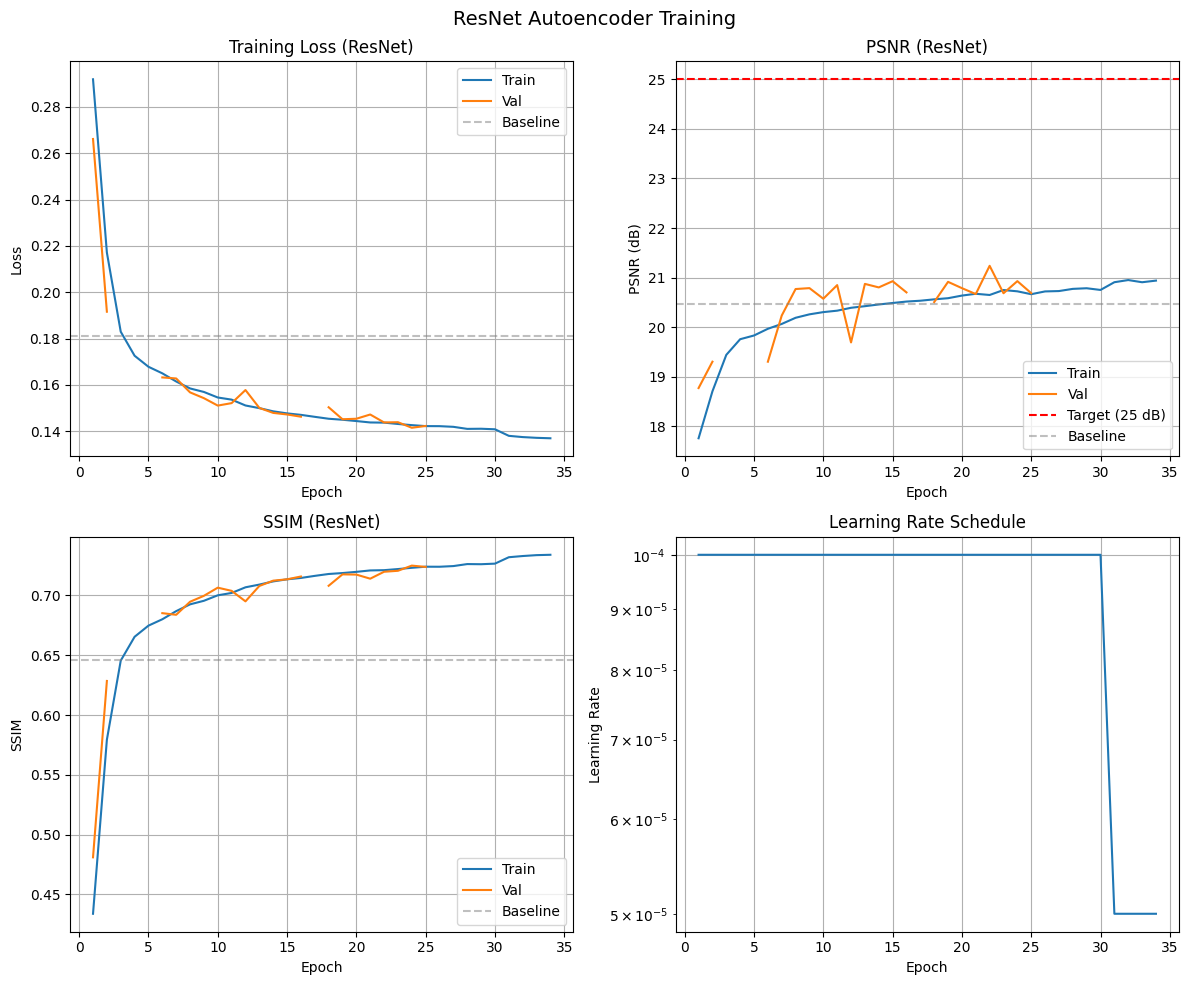


Saved training curves to: runs\resnet_lite_c16\training_curves.png


In [13]:
import matplotlib.pyplot as plt

if history:
    epochs_list = [h['epoch'] + 1 for h in history]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Loss
    ax = axes[0, 0]
    ax.plot(epochs_list, [h['train_loss'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_loss'] for h in history], label='Val')
    ax.axhline(y=baseline_results['loss'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss (ResNet)')
    ax.legend()
    ax.grid(True)
    
    # PSNR
    ax = axes[0, 1]
    ax.plot(epochs_list, [h['train_psnr'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_psnr'] for h in history], label='Val')
    ax.axhline(y=25, color='r', linestyle='--', label='Target (25 dB)')
    ax.axhline(y=baseline_results['psnr'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('PSNR (dB)')
    ax.set_title('PSNR (ResNet)')
    ax.legend()
    ax.grid(True)
    
    # SSIM
    ax = axes[1, 0]
    ax.plot(epochs_list, [h['train_ssim'] for h in history], label='Train')
    ax.plot(epochs_list, [h['val_ssim'] for h in history], label='Val')
    ax.axhline(y=baseline_results['ssim'], color='gray', linestyle='--', alpha=0.5, label='Baseline')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('SSIM')
    ax.set_title('SSIM (ResNet)')
    ax.legend()
    ax.grid(True)
    
    # Learning Rate
    ax = axes[1, 1]
    ax.plot(epochs_list, [h['learning_rate'] for h in history])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate Schedule')
    ax.set_yscale('log')
    ax.grid(True)
    
    plt.suptitle('ResNet Autoencoder Training', fontsize=14)
    plt.tight_layout()
    plt.savefig(trainer.log_dir / 'training_curves.png', dpi=150)
    plt.show()
    
    print(f"\nSaved training curves to: {trainer.log_dir / 'training_curves.png'}")

## 11. Sample Reconstructions

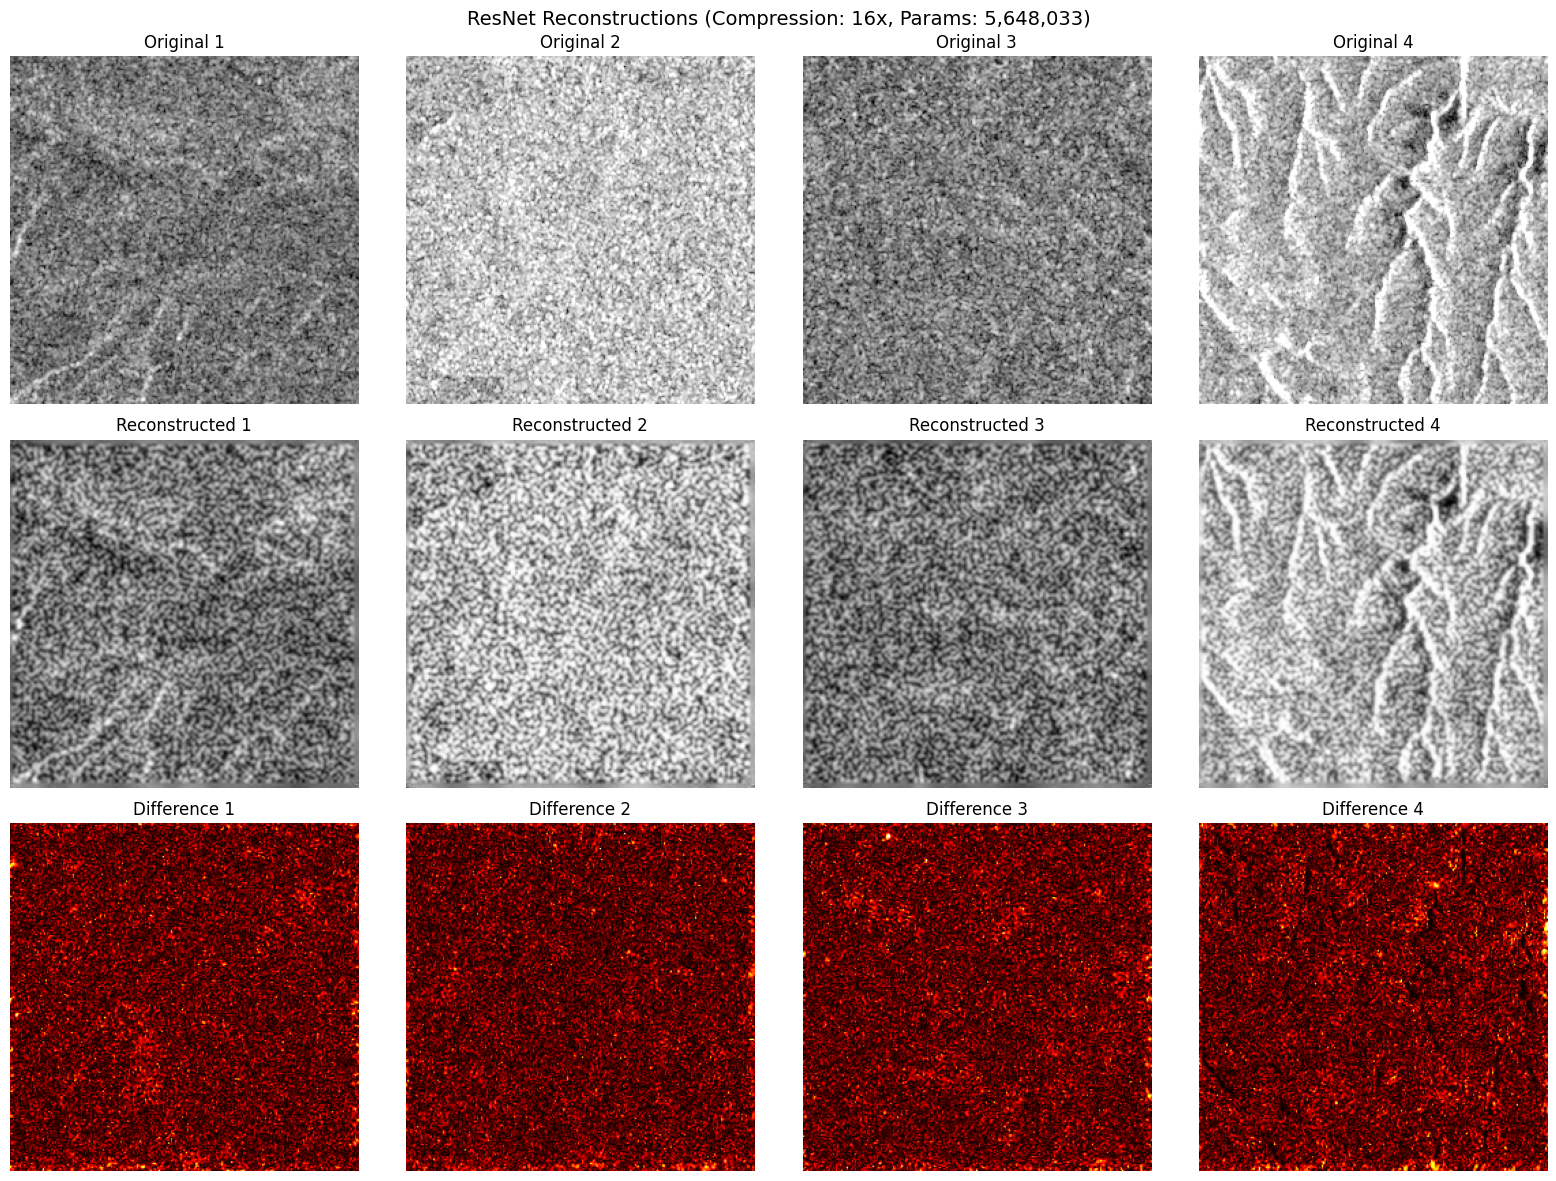

In [14]:
# Visualize some sample reconstructions
import matplotlib.pyplot as plt

model.eval()
device = next(model.parameters()).device

# Get a batch from validation
val_batch = next(iter(val_loader))[:4].to(device)

with torch.no_grad():
    reconstructed, latent = model(val_batch)

# Move to CPU for plotting
originals = val_batch.cpu().numpy()
reconstructions = reconstructed.cpu().numpy()

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i in range(4):
    # Original
    axes[0, i].imshow(originals[i, 0], cmap='gray')
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Reconstruction
    axes[1, i].imshow(reconstructions[i, 0], cmap='gray')
    axes[1, i].set_title(f'Reconstructed {i+1}')
    axes[1, i].axis('off')
    
    # Difference
    diff = abs(originals[i, 0] - reconstructions[i, 0])
    axes[2, i].imshow(diff, cmap='hot', vmin=0, vmax=0.5)
    axes[2, i].set_title(f'Difference {i+1}')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
axes[2, 0].set_ylabel('Difference', fontsize=12)

plt.suptitle(f'ResNet Reconstructions (Compression: {model.get_compression_ratio():.0f}x, Params: {params["total"]:,})', fontsize=14)
plt.tight_layout()
plt.savefig(trainer.log_dir / 'sample_reconstructions.png', dpi=150)
plt.show()

---

## Done!

**Compare in TensorBoard:**
```bash
tensorboard --logdir=D:/Projects/CNNAutoencoderProject/notebooks/runs
```

Select both `baseline_c16_fast` and `resnet_c16` to compare metrics.

**Next steps:**
- If ResNet still < 25 dB: Try U-Net architecture
- If ResNet >= 25 dB: Proceed to Phase 3 (SAR Evaluation)